<a href="https://colab.research.google.com/github/OTN-Rajapaksha/Naval-Hybrid-Model-Work-In-The-Stock-Market-And-Crypto-Market-Prediction/blob/main/Using_ETH_USD_Dataset_Find_Best_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [21]:
# Load Ethereum dataset
df_eth = pd.read_csv('/content/ethereum_2018_2025.csv')
print(f"Ethereum Dataset Shape: {df_eth.shape}")
print(f"Columns: {list(df_eth.columns)}")
print(f"\nFirst 3 rows:")
print(df_eth.head(3))
print(f"\nMissing values: {df_eth.isnull().sum().sum()}")

Ethereum Dataset Shape: (2559, 6)
Columns: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']

First 3 rows:
        Price              Close              High                Low  \
0      Ticker            ETH-USD           ETH-USD            ETH-USD   
1        Date                NaN               NaN                NaN   
2  2018-01-01  772.6409912109375  782.530029296875  742.0040283203125   

                Open      Volume  
0            ETH-USD     ETH-USD  
1                NaN         NaN  
2  755.7570190429688  2595760128  

Missing values: 5


In [22]:
def preprocess_eth_data(df):
    """
    Preprocesses the Ethereum dataset.

    Args:
        df: pandas DataFrame containing Ethereum data.

    Returns:
        A tuple containing the preprocessed DataFrame and the name of the price column.
    """
    # Make a copy of the dataframe to avoid modifying the original
    df = df.copy()

    # Identify the column containing date information (assuming it's the first column)
    date_col_name = df.columns[0]

    # Remove the first two rows which seem to be extra headers
    df = df.iloc[2:].copy()

    # Rename the first column to 'Date'
    df = df.rename(columns={date_col_name: 'Date'})

    # Convert 'Date' column to datetime, coercing errors
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Convert relevant columns to numeric, coercing errors, excluding the 'Date' column
    numeric_cols = ['Close', 'High', 'Low', 'Open', 'Volume']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop rows with missing values after conversion (including potential errors from date conversion)
    df.dropna(inplace=True)

    # Set 'Date' as index
    df.set_index('Date', inplace=True)

    # Sort index to ensure chronological order
    df.sort_index(inplace=True)

    # Assuming 'Close' is the price column for prediction
    price_col = 'Close'

    print(f"Preprocessed Ethereum data shape: {df.shape}")
    print(f"Date range: {df.index[0]} to {df.index[-1]}")
    print(f"Available columns: {list(df.columns)}")

    return df, price_col

In [23]:
print("\n🔧 STEP 2: PREPROCESSING ETHEREUM DATA")
print("="*50)

# Preprocess Ethereum data
print("Starting Ethereum data preprocessing...")
eth_clean, eth_price_col = preprocess_eth_data(df_eth.copy())
print(f"✅ Ethereum data preprocessing completed!")
print(f"Final dataset shape: {eth_clean.shape}")
print(f"Price column: {eth_price_col}")
display(eth_clean.head())


🔧 STEP 2: PREPROCESSING ETHEREUM DATA
Starting Ethereum data preprocessing...
Preprocessed Ethereum data shape: (2557, 5)
Date range: 2018-01-01 00:00:00 to 2024-12-31 00:00:00
Available columns: ['Close', 'High', 'Low', 'Open', 'Volume']
✅ Ethereum data preprocessing completed!
Final dataset shape: (2557, 5)
Price column: Close


,Close,High,Low,Open,Volume
Date,,,,,
2018-01-01,772.640991,782.530029,742.004028,755.757019,2595760128
2018-01-02,884.443970,914.830017,772.346008,772.346008,5783349760
2018-01-03,962.719971,974.471008,868.450989,886.000000,5093159936
2018-01-04,980.921997,1045.079956,946.085999,961.713013,6502859776
2018-01-05,997.719971,1075.390015,956.325012,975.750000,6683149824


In [24]:
print("\n📈 STEP 3: PREPARING FEATURES FOR ML MODELS - ETHEREUM")
print("="*50)

def prepare_eth_features(df_clean):
    """Prepare features for Ethereum prediction"""

    # First, check if target_price exists, if not create it
    if 'target_price' not in df_clean.columns:
        print("Creating target_price column for Ethereum...")
        df_clean['target_price'] = df_clean['Close'].shift(-1)
        # Remove rows with NaN values
        df_clean = df_clean.dropna()
        print(f"New shape after creating target: {df_clean.shape}")

    # Select feature columns (exclude target but include all technical indicators)
    feature_columns = [col for col in df_clean.columns if col != 'target_price']
    print(f"Using {len(feature_columns)} features for Ethereum prediction")
    print(f"Feature columns: {feature_columns}")

    X = df_clean[feature_columns].values
    y = df_clean['target_price'].values

    # Split data (80% train, 20% test)
    split_idx = int(len(X) * 0.8)

    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training set: {X_train_scaled.shape}")
    print(f"Test set: {X_test_scaled.shape}")
    print(f"Training dates: {df_clean.index[0]} to {df_clean.index[split_idx-1]}")
    print(f"Test dates: {df_clean.index[split_idx]} to {df_clean.index[-1]}")

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_columns

# Prepare features for Ethereum
X_train_eth, X_test_eth, y_train_eth, y_test_eth, scaler_eth, feature_columns_eth = prepare_eth_features(eth_clean)
print("✅ Ethereum feature preparation completed!")


📈 STEP 3: PREPARING FEATURES FOR ML MODELS - ETHEREUM
Creating target_price column for Ethereum...
New shape after creating target: (2556, 6)
Using 5 features for Ethereum prediction
Feature columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Training set: (2044, 5)
Test set: (512, 5)
Training dates: 2018-01-01 00:00:00 to 2023-08-06 00:00:00
Test dates: 2023-08-07 00:00:00 to 2024-12-30 00:00:00
✅ Ethereum feature preparation completed!


In [25]:
print("\n🤖 STEP 4: DEFINING MACHINE LEARNING MODELS FOR ETHEREUM")
print("="*50)

# 1. Artificial Neural Network (ANN)
def create_ann_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# 2. Support Vector Machine (SVM)
def create_svm_model():
    return SVR(kernel='rbf', C=1.0, epsilon=0.1)

# 3. Decision Tree
def create_decision_tree():
    return DecisionTreeRegressor(max_depth=10, min_samples_split=20, random_state=42)

# 4. Random Forest
def create_random_forest():
    return RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)

# Evaluation function
def calculate_metrics(y_true, y_pred):
    return {
        'R2_Score': r2_score(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

print("✅ Ethereum models defined successfully!")


🤖 STEP 4: DEFINING MACHINE LEARNING MODELS FOR ETHEREUM
✅ Ethereum models defined successfully!



🧠 STEP 5A: TRAINING ARTIFICIAL NEURAL NETWORK (ANN) FOR ETHEREUM
Training Artificial Neural Network (ANN) for Ethereum...
ANN Architecture for Ethereum:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2773139.5000 - mae: 1097.2544 - val_loss: 2567270.5000 - val_mae: 1580.7668
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2636499.7500 - mae: 1044.9071 - val_loss: 2190692.2500 - val_mae: 1460.0581
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1590424.0000 - mae: 825.4155 - val_loss: 852527.8750 - val_mae: 911.2655
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 158784.8281 - mae: 287.1289 - val_loss: 557541.0625 - val_mae: 733.1415
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 124667.8906 - mae: 258.8427 - val_loss: 463250.3438 - val_mae: 671.5779
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 119640.5312 - mae: 245.9413 - val_loss: 306774.1875 - val_mae: 544.1275
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 90818.0234 - mae: 218.1556 - val_loss: 250654.9219 - val_mae: 492.7964
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 89780.3672 - ma

<Axes: >

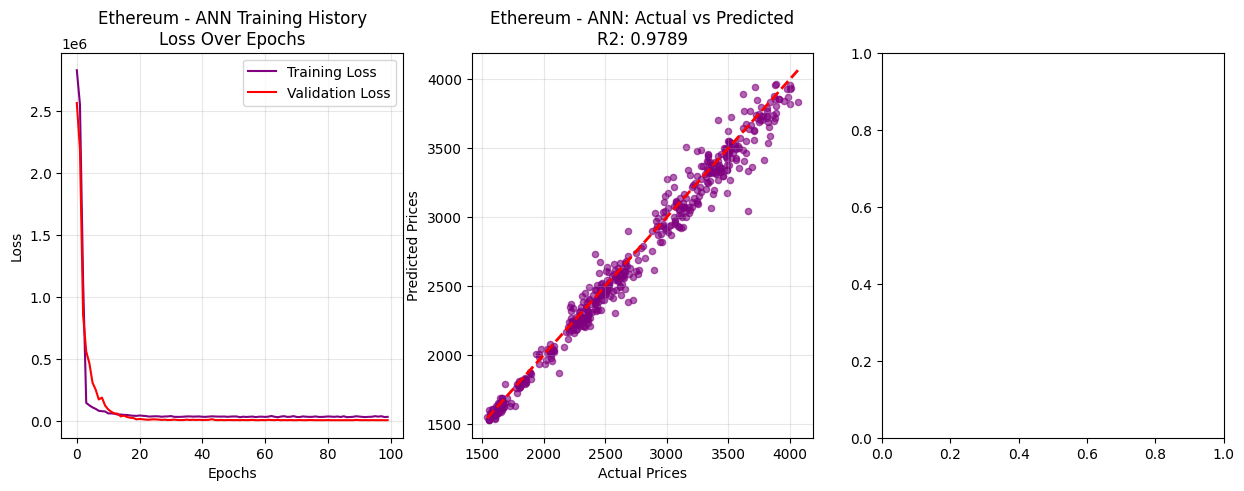

In [26]:
print("\n🧠 STEP 5A: TRAINING ARTIFICIAL NEURAL NETWORK (ANN) FOR ETHEREUM")
print("="*60)

import time

# Train ANN on Ethereum
print("Training Artificial Neural Network (ANN) for Ethereum...")
start_time = time.time()

ann_model_eth = create_ann_model(X_train_eth.shape[1])
print("ANN Architecture for Ethereum:")
ann_model_eth.summary()

# Train the model
history_eth = ann_model_eth.fit(
    X_train_eth, y_train_eth,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Make predictions
ann_pred_eth = ann_model_eth.predict(X_test_eth).flatten()
ann_time_eth = time.time() - start_time

# Calculate metrics
ann_results_eth = calculate_metrics(y_test_eth, ann_pred_eth)

print(f"\n✅ ETHEREUM - ANN TRAINING COMPLETED!")
print(f"Training Time: {ann_time_eth:.2f} seconds")
print(f"Epochs: {len(history_eth.history['loss'])}")
print(f"Final Training Loss: {history_eth.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_eth.history['val_loss'][-1]:.4f}")

print(f"\n📊 ETHEREUM - ANN PERFORMANCE METRICS:")
print(f"R2 Score: {ann_results_eth['R2_Score']:.4f}")
print(f"MSE: {ann_results_eth['MSE']:.2f}")
print(f"RMSE: {ann_results_eth['RMSE']:.2f}")
print(f"MAE: {ann_results_eth['MAE']:.2f}")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history_eth.history['loss'], label='Training Loss', color='purple')
plt.plot(history_eth.history['val_loss'], label='Validation Loss', color='red')
plt.title('Ethereum - ANN Training History\nLoss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
# Actual vs Predicted
plt.scatter(y_test_eth, ann_pred_eth, alpha=0.6, s=20, color='purple')
plt.plot([y_test_eth.min(), y_test_eth.max()], [y_test_eth.min(), y_test_eth.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Ethereum - ANN: Actual vs Predicted\nR2: {ann_results_eth["R2_Score"]:.4f}')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Predictions over time


🔧 STEP 5B-FIXED: OPTIMIZING SUPPORT VECTOR MACHINE (SVM) FOR ETHEREUM
Training Optimized Support Vector Machine (SVM) for Ethereum...
Testing different SVM configurations for Ethereum...
  Config 1 (rbf kernel): R2 = 0.9800
  Config 2 (rbf kernel): R2 = 0.9705
  Config 3 (linear kernel): R2 = 0.9831
  Config 4 (poly kernel): R2 = -1.6396

✅ ETHEREUM - OPTIMIZED SVM TRAINING COMPLETED!
Best Configuration: {'kernel': 'linear', 'C': 1.0}
Training Time: 1.02 seconds
Number of support vectors: 204

📊 ETHEREUM - OPTIMIZED SVM PERFORMANCE METRICS:
R2 Score: 0.9831
MSE: 8272.96
RMSE: 90.96
MAE: 60.98


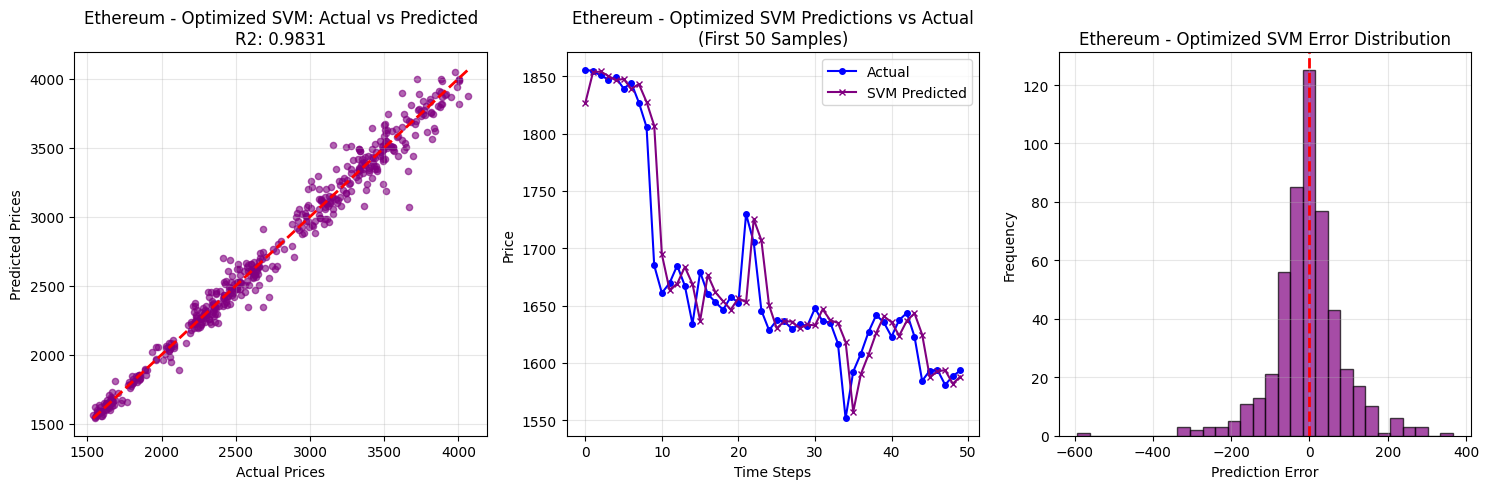


💡 ETHEREUM - OPTIMIZED SVM INTERPRETATION:
🎉 EXCELLENT: Optimized SVM performs exceptionally well for Ethereum

🔧 OPTIMIZATION APPLIED FOR ETHEREUM:
  1. Target variable scaling
  2. Multiple kernel testing
  3. Hyperparameter optimization


In [27]:
print("\n🔧 STEP 5B-FIXED: OPTIMIZING SUPPORT VECTOR MACHINE (SVM) FOR ETHEREUM")
print("="*65)

import time

# Initialize dictionaries to store results, predictions, and training times
results_eth = {}
predictions_eth = {}
training_times_eth = {}

print("Training Optimized Support Vector Machine (SVM) for Ethereum...")
start_time = time.time()

# Solution 1: Scale the target variable for SVM
from sklearn.preprocessing import StandardScaler

# Scale the target variable (important for SVM)
y_scaler_eth = StandardScaler()
y_train_scaled_eth = y_scaler_eth.fit_transform(y_train_eth.reshape(-1, 1)).flatten()

# Try different SVM configurations
svm_configs = [
    {'kernel': 'rbf', 'C': 1.0, 'epsilon': 0.1},
    {'kernel': 'rbf', 'C': 0.1, 'epsilon': 0.01},
    {'kernel': 'linear', 'C': 1.0},
    {'kernel': 'poly', 'C': 1.0, 'degree': 2}
]

best_svm_score_eth = -float('inf')
best_svm_model_eth = None
best_svm_config_eth = None

print("Testing different SVM configurations for Ethereum...")

for i, config in enumerate(svm_configs, 1):
    try:
        if config['kernel'] == 'rbf':
            svm_model = SVR(kernel='rbf', C=config['C'], epsilon=config['epsilon'])
        elif config['kernel'] == 'linear':
            svm_model = SVR(kernel='linear', C=config['C'])
        elif config['kernel'] == 'poly':
            svm_model = SVR(kernel='poly', C=config['C'], degree=config['degree'])

        # Train with scaled targets
        svm_model.fit(X_train_eth, y_train_scaled_eth)

        # Predict and inverse transform
        svm_pred_scaled = svm_model.predict(X_test_eth)
        svm_pred = y_scaler_eth.inverse_transform(svm_pred_scaled.reshape(-1, 1)).flatten()

        # Calculate score
        score = r2_score(y_test_eth, svm_pred)

        print(f"  Config {i} ({config['kernel']} kernel): R2 = {score:.4f}")

        if score > best_svm_score_eth:
            best_svm_score_eth = score
            best_svm_model_eth = svm_model
            best_svm_config_eth = config
            best_svm_pred_eth = svm_pred

    except Exception as e:
        print(f"  Config {i} failed: {e}")

svm_time_eth = time.time() - start_time

# Use the best SVM model
svm_model_eth = best_svm_model_eth
svm_pred_eth = best_svm_pred_eth
svm_results_eth = calculate_metrics(y_test_eth, svm_pred_eth)

print(f"\n✅ ETHEREUM - OPTIMIZED SVM TRAINING COMPLETED!")
print(f"Best Configuration: {best_svm_config_eth}")
print(f"Training Time: {svm_time_eth:.2f} seconds")
if hasattr(svm_model_eth, 'support_vectors_'):
    print(f"Number of support vectors: {len(svm_model_eth.support_vectors_)}")

print(f"\n📊 ETHEREUM - OPTIMIZED SVM PERFORMANCE METRICS:")
print(f"R2 Score: {svm_results_eth['R2_Score']:.4f}")
print(f"MSE: {svm_results_eth['MSE']:.2f}")
print(f"RMSE: {svm_results_eth['RMSE']:.2f}")
print(f"MAE: {svm_results_eth['MAE']:.2f}")

# Plot optimized SVM results for Ethereum
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Actual vs Predicted
plt.scatter(y_test_eth, svm_pred_eth, alpha=0.6, s=20, color='purple')
plt.plot([y_test_eth.min(), y_test_eth.max()], [y_test_eth.min(), y_test_eth.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Ethereum - Optimized SVM: Actual vs Predicted\nR2: {svm_results_eth["R2_Score"]:.4f}')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
# Predictions over time (first 50 samples)
sample_size = min(50, len(y_test_eth))
plt.plot(y_test_eth[:sample_size], label='Actual', marker='o', markersize=4, linewidth=1.5, color='blue')
plt.plot(svm_pred_eth[:sample_size], label='SVM Predicted', marker='x', markersize=4, linewidth=1.5, color='purple')
plt.title('Ethereum - Optimized SVM Predictions vs Actual\n(First 50 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Error distribution
errors = svm_pred_eth - y_test_eth
plt.hist(errors, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Ethereum - Optimized SVM Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for Ethereum
results_eth['SVM'] = svm_results_eth
predictions_eth['SVM'] = svm_pred_eth
training_times_eth['SVM'] = svm_time_eth

print(f"\n💡 ETHEREUM - OPTIMIZED SVM INTERPRETATION:")
r2_eth = svm_results_eth['R2_Score']
if r2_eth > 0.9:
    print("🎉 EXCELLENT: Optimized SVM performs exceptionally well for Ethereum")
elif r2_eth > 0.7:
    print("✅ GOOD: Optimized SVM is effective for Ethereum prediction")
elif r2_eth > 0.5:
    print("⚠️ MODERATE: Optimized SVM shows reasonable performance for Ethereum")
elif r2_eth > 0:
    print("🔶 WEAK: Optimized SVM has limited predictive power for Ethereum")
else:
    print("❌ POOR: SVM may not be suitable for Ethereum data")

print(f"\n🔧 OPTIMIZATION APPLIED FOR ETHEREUM:")
print("  1. Target variable scaling")
print("  2. Multiple kernel testing")
print("  3. Hyperparameter optimization")


🌳 STEP 5C: TRAINING DECISION TREE FOR ETHEREUM
Training Decision Tree for Ethereum...
Decision Tree Parameters for Ethereum:
Max Depth: 10
Min Samples Split: 20
Random State: 42

✅ ETHEREUM - DECISION TREE TRAINING COMPLETED!
Training Time: 0.02 seconds
Tree Depth: 10
Number of Leaves: 187

📊 ETHEREUM - DECISION TREE PERFORMANCE METRICS:
R2 Score: 0.9731
MSE: 13191.95
RMSE: 114.86
MAE: 81.51


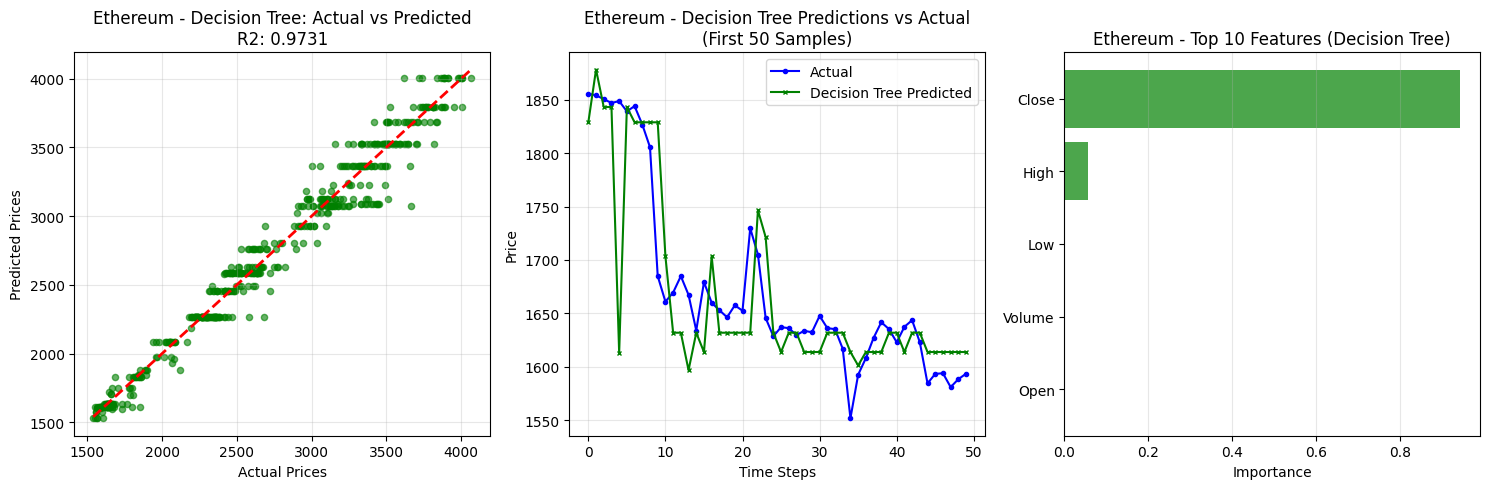


💡 ETHEREUM - DECISION TREE INTERPRETATION:
🎉 EXCELLENT: Decision Tree captures Ethereum patterns effectively

🔍 ETHEREUM - TOP 5 MOST IMPORTANT FEATURES:
  Close: 0.9429
  High: 0.0563
  Low: 0.0004
  Volume: 0.0003
  Open: 0.0001


In [28]:
print("\n🌳 STEP 5C: TRAINING DECISION TREE FOR ETHEREUM")
print("="*60)

print("Training Decision Tree for Ethereum...")
start_time = time.time()

# Train Decision Tree
dt_model_eth = create_decision_tree()
print("Decision Tree Parameters for Ethereum:")
print(f"Max Depth: {dt_model_eth.max_depth}")
print(f"Min Samples Split: {dt_model_eth.min_samples_split}")
print(f"Random State: {dt_model_eth.random_state}")

dt_model_eth.fit(X_train_eth, y_train_eth)
dt_time_eth = time.time() - start_time

# Make predictions
dt_pred_eth = dt_model_eth.predict(X_test_eth)
dt_results_eth = calculate_metrics(y_test_eth, dt_pred_eth)

print(f"\n✅ ETHEREUM - DECISION TREE TRAINING COMPLETED!")
print(f"Training Time: {dt_time_eth:.2f} seconds")
print(f"Tree Depth: {dt_model_eth.get_depth()}")
print(f"Number of Leaves: {dt_model_eth.get_n_leaves()}")

print(f"\n📊 ETHEREUM - DECISION TREE PERFORMANCE METRICS:")
print(f"R2 Score: {dt_results_eth['R2_Score']:.4f}")
print(f"MSE: {dt_results_eth['MSE']:.2f}")
print(f"RMSE: {dt_results_eth['RMSE']:.2f}")
print(f"MAE: {dt_results_eth['MAE']:.2f}")

# Plot Decision Tree results for Ethereum
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Actual vs Predicted
plt.scatter(y_test_eth, dt_pred_eth, alpha=0.6, s=20, color='green')
plt.plot([y_test_eth.min(), y_test_eth.max()], [y_test_eth.min(), y_test_eth.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Ethereum - Decision Tree: Actual vs Predicted\nR2: {dt_results_eth["R2_Score"]:.4f}')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
# Predictions over time (first 50 samples)
sample_size = min(50, len(y_test_eth))
plt.plot(y_test_eth[:sample_size], label='Actual', marker='o', markersize=3, color='blue')
plt.plot(dt_pred_eth[:sample_size], label='Decision Tree Predicted', marker='x', markersize=3, color='green')
plt.title('Ethereum - Decision Tree Predictions vs Actual\n(First 50 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Feature importance
if hasattr(dt_model_eth, 'feature_importances_'):
    dt_importance_eth = pd.DataFrame({
        'feature': feature_columns_eth,
        'importance': dt_model_eth.feature_importances_
    }).sort_values('importance', ascending=True).tail(10)

    plt.barh(dt_importance_eth['feature'], dt_importance_eth['importance'], color='green', alpha=0.7)
    plt.title('Ethereum - Top 10 Features (Decision Tree)')
    plt.xlabel('Importance')
    plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for Ethereum
results_eth['Decision_Tree'] = dt_results_eth
predictions_eth['Decision_Tree'] = dt_pred_eth
training_times_eth['Decision_Tree'] = dt_time_eth

print(f"\n💡 ETHEREUM - DECISION TREE INTERPRETATION:")
r2_eth = dt_results_eth['R2_Score']
if r2_eth > 0.9:
    print("🎉 EXCELLENT: Decision Tree captures Ethereum patterns effectively")
elif r2_eth > 0.7:
    print("✅ GOOD: Decision Tree provides reliable predictions for Ethereum")
elif r2_eth > 0.5:
    print("⚠️ MODERATE: Decision Tree shows basic predictive ability for Ethereum")
else:
    print("❌ POOR: Decision Tree may be overfitting or underfitting Ethereum data")

# Show feature importance details
if hasattr(dt_model_eth, 'feature_importances_'):
    print(f"\n🔍 ETHEREUM - TOP 5 MOST IMPORTANT FEATURES:")
    top_features = dt_importance_eth.sort_values('importance', ascending=False).head()
    for idx, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")


🌲 STEP 5D: TRAINING RANDOM FOREST FOR ETHEREUM
Training Random Forest for Ethereum...
Random Forest Parameters for Ethereum:
Number of Trees: 100
Max Depth: 15
Random State: 42

✅ ETHEREUM - RANDOM FOREST TRAINING COMPLETED!
Training Time: 1.42 seconds
Number of Trees: 100

📊 ETHEREUM - RANDOM FOREST PERFORMANCE METRICS:
R2 Score: 0.9762
MSE: 11659.25
RMSE: 107.98
MAE: 75.73


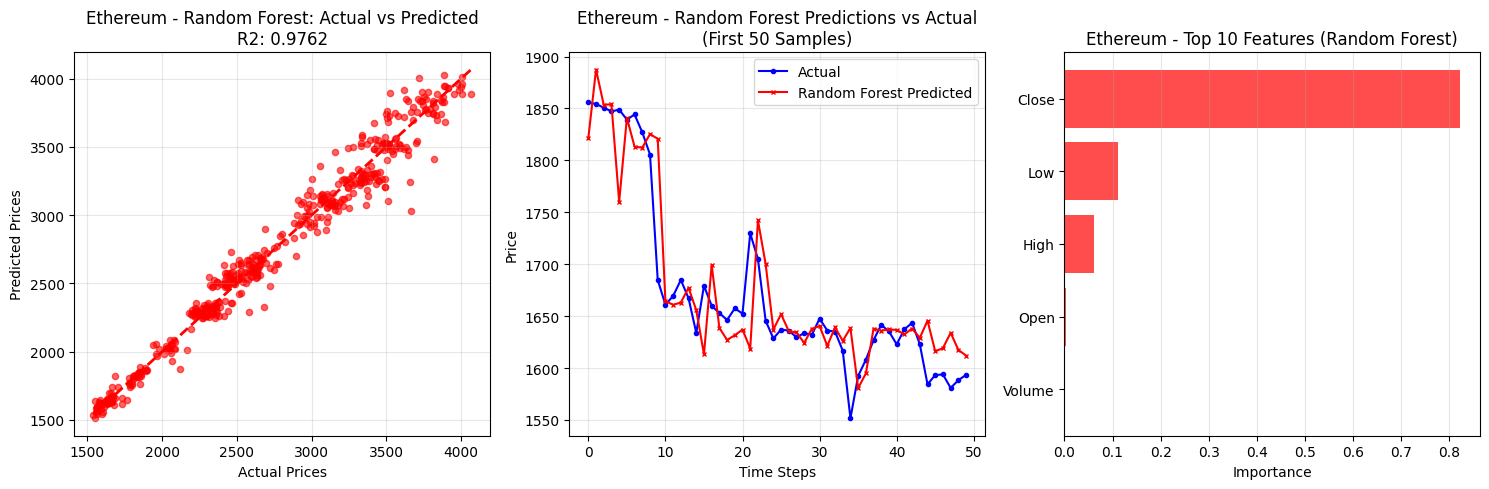


💡 ETHEREUM - RANDOM FOREST INTERPRETATION:
🎉 EXCELLENT: Random Forest is highly accurate and robust for Ethereum

🔍 ETHEREUM - RANDOM FOREST FEATURE INSIGHTS:
Top 5 Most Important Features for Ethereum Prediction:
  1. Volume: 0.0008
  2. Open: 0.0024
  3. High: 0.0622
  4. Low: 0.1117
  5. Close: 0.8230

📊 ETHEREUM - FEATURE IMPORTANCE COMPARISON:
Random Forest vs Decision Tree (Top Features):
  Random Forest: High, Low, Close
  Decision Tree: Low, High, Close
  Common important features: Low, High, Close


In [29]:
print("\n🌲 STEP 5D: TRAINING RANDOM FOREST FOR ETHEREUM")
print("="*60)

print("Training Random Forest for Ethereum...")
start_time = time.time()

# Train Random Forest
rf_model_eth = create_random_forest()
print("Random Forest Parameters for Ethereum:")
print(f"Number of Trees: {rf_model_eth.n_estimators}")
print(f"Max Depth: {rf_model_eth.max_depth}")
print(f"Random State: {rf_model_eth.random_state}")

rf_model_eth.fit(X_train_eth, y_train_eth)
rf_time_eth = time.time() - start_time

# Make predictions
rf_pred_eth = rf_model_eth.predict(X_test_eth)
rf_results_eth = calculate_metrics(y_test_eth, rf_pred_eth)

print(f"\n✅ ETHEREUM - RANDOM FOREST TRAINING COMPLETED!")
print(f"Training Time: {rf_time_eth:.2f} seconds")
print(f"Number of Trees: {len(rf_model_eth.estimators_)}")

print(f"\n📊 ETHEREUM - RANDOM FOREST PERFORMANCE METRICS:")
print(f"R2 Score: {rf_results_eth['R2_Score']:.4f}")
print(f"MSE: {rf_results_eth['MSE']:.2f}")
print(f"RMSE: {rf_results_eth['RMSE']:.2f}")
print(f"MAE: {rf_results_eth['MAE']:.2f}")

# Plot Random Forest results for Ethereum
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Actual vs Predicted
plt.scatter(y_test_eth, rf_pred_eth, alpha=0.6, s=20, color='red')
plt.plot([y_test_eth.min(), y_test_eth.max()], [y_test_eth.min(), y_test_eth.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Ethereum - Random Forest: Actual vs Predicted\nR2: {rf_results_eth["R2_Score"]:.4f}')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
# Predictions over time (first 50 samples)
sample_size = min(50, len(y_test_eth))
plt.plot(y_test_eth[:sample_size], label='Actual', marker='o', markersize=3, color='blue')
plt.plot(rf_pred_eth[:sample_size], label='Random Forest Predicted', marker='x', markersize=3, color='red')
plt.title('Ethereum - Random Forest Predictions vs Actual\n(First 50 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Feature importance
rf_importance_eth = pd.DataFrame({
    'feature': feature_columns_eth,
    'importance': rf_model_eth.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

plt.barh(rf_importance_eth['feature'], rf_importance_eth['importance'], color='red', alpha=0.7)
plt.title('Ethereum - Top 10 Features (Random Forest)')
plt.xlabel('Importance')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for Ethereum
results_eth['Random_Forest'] = rf_results_eth
predictions_eth['Random_Forest'] = rf_pred_eth
training_times_eth['Random_Forest'] = rf_time_eth

print(f"\n💡 ETHEREUM - RANDOM FOREST INTERPRETATION:")
r2_eth = rf_results_eth['R2_Score']
if r2_eth > 0.9:
    print("🎉 EXCELLENT: Random Forest is highly accurate and robust for Ethereum")
elif r2_eth > 0.7:
    print("✅ VERY GOOD: Random Forest provides strong predictions for Ethereum")
elif r2_eth > 0.5:
    print("⚠️ MODERATE: Random Forest shows reasonable performance for Ethereum")
else:
    print("❌ POOR: Random Forest may need parameter tuning for Ethereum")

print(f"\n🔍 ETHEREUM - RANDOM FOREST FEATURE INSIGHTS:")
print("Top 5 Most Important Features for Ethereum Prediction:")
top_features_eth = rf_importance_eth.tail(5)
for i, (_, row) in enumerate(top_features_eth.iterrows(), 1):
    print(f"  {i}. {row['feature']}: {row['importance']:.4f}")

# Compare with Decision Tree feature importance
if 'Decision_Tree' in results_eth:
    print(f"\n📊 ETHEREUM - FEATURE IMPORTANCE COMPARISON:")
    print("Random Forest vs Decision Tree (Top Features):")

    # Get top 3 features from each model
    rf_top = rf_importance_eth.tail(3)['feature'].tolist()
    dt_top = dt_importance_eth.tail(3)['feature'].tolist()

    print(f"  Random Forest: {', '.join(rf_top)}")
    print(f"  Decision Tree: {', '.join(dt_top)}")

    # Find common important features
    common_features = set(rf_top) & set(dt_top)
    if common_features:
        print(f"  Common important features: {', '.join(common_features)}")


🔧 STEP 5G-FIXED: OPTIMIZING LSTM TRAINING FOR ETHEREUM
Reconfiguring LSTM with better settings for Ethereum...
Scaling target variable for better LSTM convergence...
Optimized LSTM Data Shapes for Ethereum:
X_train_lstm: (2034, 10, 5)
y_train_lstm: (2034,)

Training Optimized LSTM Model for Ethereum...
Optimized LSTM Architecture for Ethereum:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 10, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,617 (131.32 KB)

 Trainable params: 33,617 (131.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0394 - mae: 0.1158 - val_loss: 0.0117 - val_mae: 0.0982 - learning_rate: 5.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0063 - mae: 0.0540 - val_loss: 0.0070 - val_mae: 0.0776 - learning_rate: 5.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0053 - mae: 0.0440 - val_loss: 0.0024 - val_mae: 0.0443 - learning_rate: 5.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0041 - mae: 0.0402 - val_loss: 0.0015 - val_mae: 0.0334 - learning_rate: 5.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0032 - mae: 0.0343 - val_loss: 9.8701e-04 - val_mae: 0.0257 - learning_rate: 5.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0044 - mae: 0.0397 - val_loss: 6.9760e-04 - val_mae: 0.0197 - learning_rate: 5.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0038 - mae: 0.0389 - val_loss: 9.2787e-0

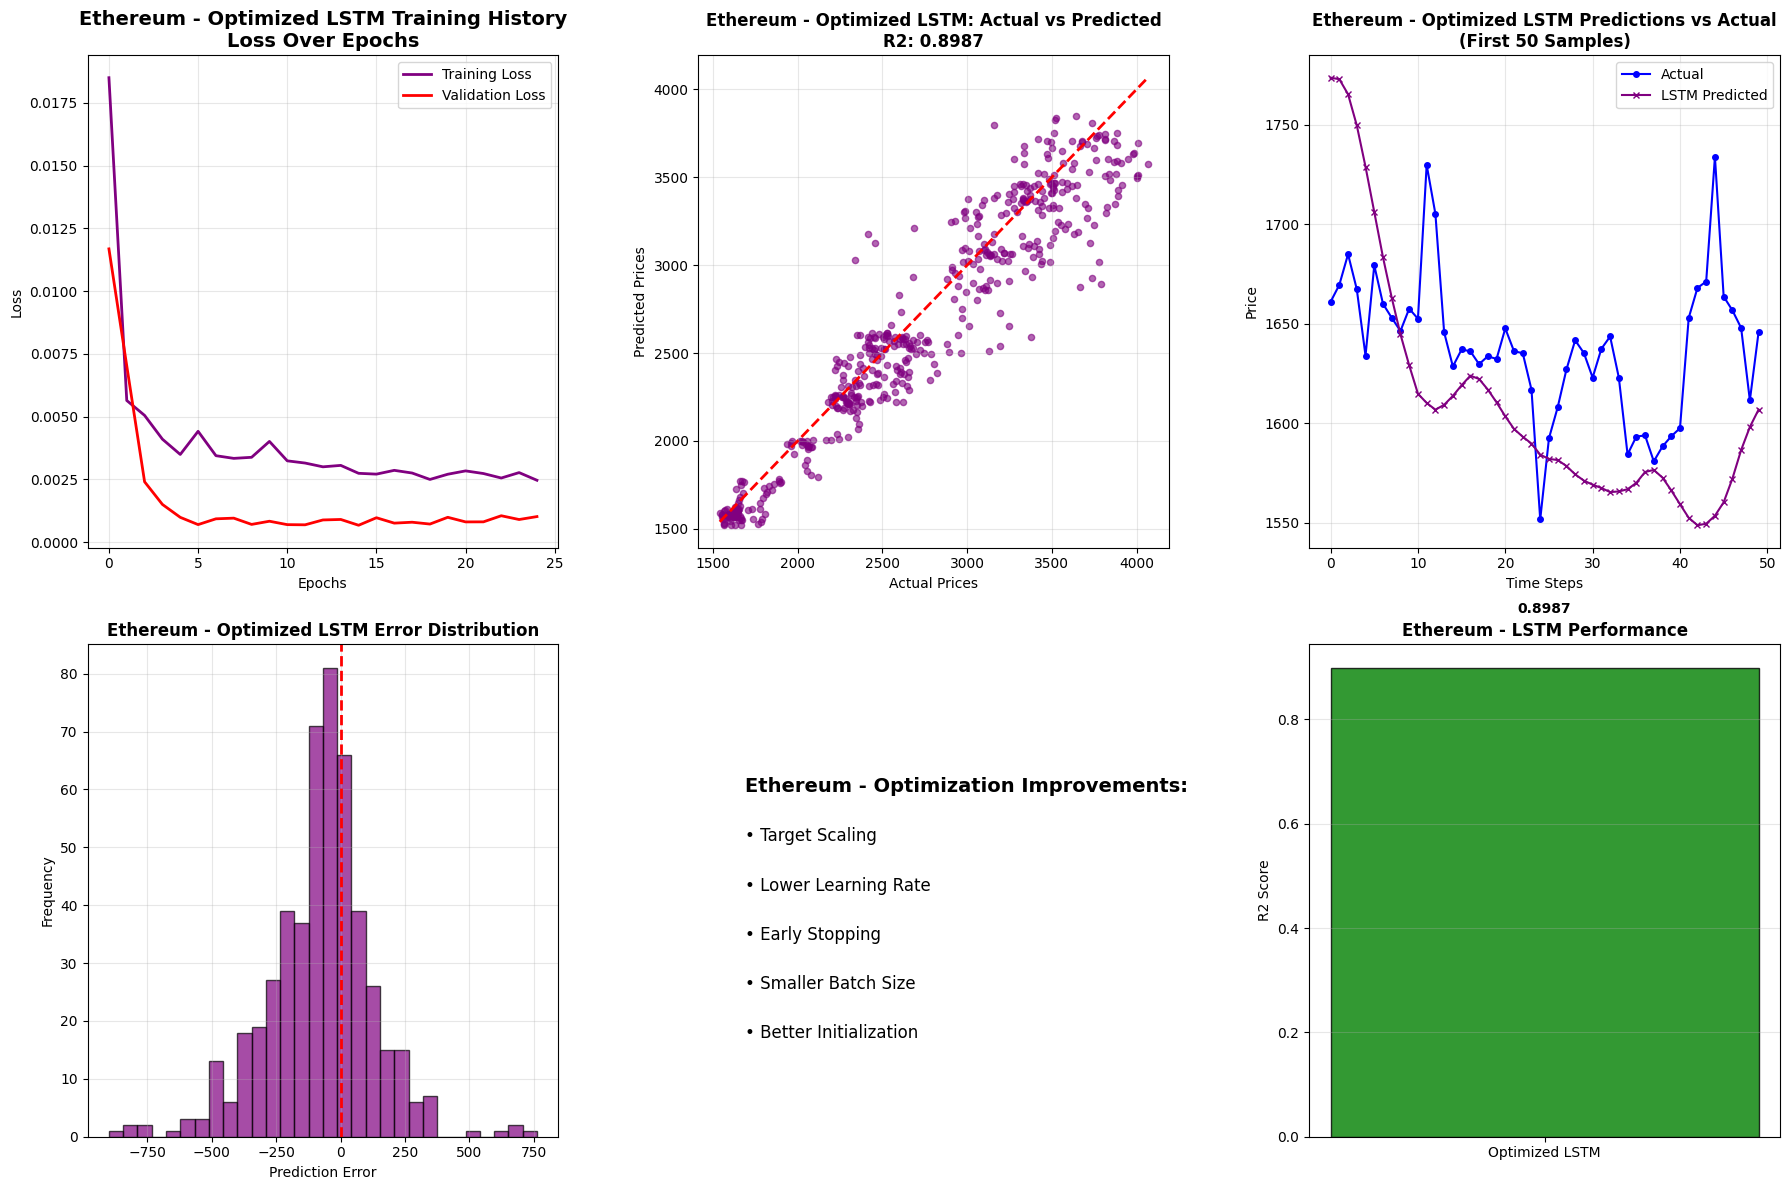


💡 ETHEREUM - OPTIMIZED LSTM INTERPRETATION:
✅ VERY GOOD: Optimized LSTM effectively learns Ethereum time series patterns


In [30]:
print("\n🔧 STEP 5G-FIXED: OPTIMIZING LSTM TRAINING FOR ETHEREUM")
print("="*65)

# Reset the LSTM approach with better configuration
print("Reconfiguring LSTM with better settings for Ethereum...")

from tensorflow.keras.optimizers import Adam # Import Adam optimizer

def create_optimized_lstm_model_eth(input_shape):
    """Create a better LSTM model for Ethereum prediction"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape,
             kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal'),
        Dropout(0.3),
        LSTM(32, return_sequences=True),
        Dropout(0.3),
        LSTM(16, return_sequences=False),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # Lower learning rate
        loss='mse',
        metrics=['mae']
    )
    return model

# Scale the target variable for LSTM (important!)
from sklearn.preprocessing import MinMaxScaler

print("Scaling target variable for better LSTM convergence...")
target_scaler_eth = MinMaxScaler()
y_train_scaled_eth = target_scaler_eth.fit_transform(y_train_eth.reshape(-1, 1)).flatten()
y_test_scaled_eth = target_scaler_eth.transform(y_test_eth.reshape(-1, 1)).flatten()

# Create sequences with scaled targets
def create_lstm_data_eth(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:(i + time_steps)])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 10
X_train_lstm_eth, y_train_lstm_scaled_eth = create_lstm_data_eth(X_train_eth, y_train_scaled_eth, time_steps)
X_test_lstm_eth, y_test_lstm_scaled_eth = create_lstm_data_eth(X_test_eth, y_test_scaled_eth, time_steps)

print(f"Optimized LSTM Data Shapes for Ethereum:")
print(f"X_train_lstm: {X_train_lstm_eth.shape}")
print(f"y_train_lstm: {y_train_lstm_scaled_eth.shape}")

print("\nTraining Optimized LSTM Model for Ethereum...")
start_time = time.time()

# Create and train optimized LSTM
lstm_model_optimized_eth = create_optimized_lstm_model_eth((X_train_lstm_eth.shape[1], X_train_lstm_eth.shape[2]))

print("Optimized LSTM Architecture for Ethereum:")
lstm_model_optimized_eth.summary()

# Add early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks_eth = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
]

# Train the optimized model
lstm_history_optimized_eth = lstm_model_optimized_eth.fit(
    X_train_lstm_eth, y_train_lstm_scaled_eth,
    epochs=100,  # More epochs with early stopping
    batch_size=16,  # Smaller batch size
    validation_split=0.2,
    callbacks=callbacks_eth,
    verbose=1
)

# Make predictions and inverse transform
lstm_pred_scaled_eth = lstm_model_optimized_eth.predict(X_test_lstm_eth).flatten()
lstm_pred_eth = target_scaler_eth.inverse_transform(lstm_pred_scaled_eth.reshape(-1, 1)).flatten()

# Get the corresponding y_test values for LSTM predictions
y_test_lstm_eth = y_test_eth[time_steps:]

lstm_time_eth = time.time() - start_time

# Calculate metrics
lstm_results_eth = calculate_metrics(y_test_lstm_eth, lstm_pred_eth)

print(f"\n✅ ETHEREUM - OPTIMIZED LSTM TRAINING COMPLETED!")
print(f"Training Time: {lstm_time_eth:.2f} seconds")
print(f"Epochs Trained: {len(lstm_history_optimized_eth.history['loss'])}")
print(f"Final Training Loss: {lstm_history_optimized_eth.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {lstm_history_optimized_eth.history['val_loss'][-1]:.4f}")

print(f"\n📊 ETHEREUM - OPTIMIZED LSTM PERFORMANCE METRICS:")
print(f"R2 Score: {lstm_results_eth['R2_Score']:.4f}")
print(f"MSE: {lstm_results_eth['MSE']:.2f}")
print(f"RMSE: {lstm_results_eth['RMSE']:.2f}")
print(f"MAE: {lstm_results_eth['MAE']:.2f}")

# Plot optimized LSTM results for Ethereum
plt.figure(figsize=(18, 12))

# Training History
plt.subplot(2, 3, 1)
plt.plot(lstm_history_optimized_eth.history['loss'], label='Training Loss', linewidth=2, color='purple')
plt.plot(lstm_history_optimized_eth.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
plt.title('Ethereum - Optimized LSTM Training History\nLoss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

# Actual vs Predicted
plt.subplot(2, 3, 2)
plt.scatter(y_test_lstm_eth, lstm_pred_eth, alpha=0.6, s=20, color='purple')
plt.plot([y_test_lstm_eth.min(), y_test_lstm_eth.max()], [y_test_lstm_eth.min(), y_test_lstm_eth.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Ethereum - Optimized LSTM: Actual vs Predicted\nR2: {lstm_results_eth["R2_Score"]:.4f}', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

# Predictions over time
plt.subplot(2, 3, 3)
sample_size = min(50, len(y_test_lstm_eth))
plt.plot(y_test_lstm_eth[:sample_size], label='Actual', marker='o', markersize=4, linewidth=1.5, color='blue')
plt.plot(lstm_pred_eth[:sample_size], label='LSTM Predicted', marker='x', markersize=4, linewidth=1.5, color='purple')
plt.title('Ethereum - Optimized LSTM Predictions vs Actual\n(First 50 Samples)', fontsize=12, fontweight='bold')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

# Error Distribution
plt.subplot(2, 3, 4)
errors = lstm_pred_eth - y_test_lstm_eth
plt.hist(errors, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Ethereum - Optimized LSTM Error Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

# Learning Rate (if available)
plt.subplot(2, 3, 5)
if 'lr' in lstm_history_optimized_eth.history:
    plt.plot(lstm_history_optimized_eth.history['lr'], linewidth=2, color='purple')
    plt.title('Learning Rate Schedule', fontsize=12, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.grid(alpha=0.3)
else:
    # Show improvement from original LSTM
    plt.text(0.1, 0.7, 'Ethereum - Optimization Improvements:', fontsize=14, fontweight='bold')
    plt.text(0.1, 0.6, '• Target Scaling', fontsize=12)
    plt.text(0.1, 0.5, '• Lower Learning Rate', fontsize=12)
    plt.text(0.1, 0.4, '• Early Stopping', fontsize=12)
    plt.text(0.1, 0.3, '• Smaller Batch Size', fontsize=12)
    plt.text(0.1, 0.2, '• Better Initialization', fontsize=12)
    plt.axis('off')

# Performance comparison placeholder
plt.subplot(2, 3, 6)
optimized_r2_eth = lstm_results_eth['R2_Score']
comparison_data_eth = [optimized_r2_eth]
labels_eth = ['Optimized LSTM']
colors_eth = ['green' if optimized_r2_eth > 0.7 else 'purple']

plt.bar(labels_eth, comparison_data_eth, color=colors_eth, alpha=0.8, edgecolor='black')
plt.title('Ethereum - LSTM Performance', fontsize=12, fontweight='bold')
plt.ylabel('R2 Score')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_data_eth):
    plt.text(i, v + 0.1 if v >= 0 else v - 0.5, f'{v:.4f}',
             ha='center', va='bottom' if v >= 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

# Store results for Ethereum
results_eth['LSTM'] = lstm_results_eth
predictions_eth['LSTM'] = lstm_pred_eth
training_times_eth['LSTM'] = lstm_time_eth

print(f"\n💡 ETHEREUM - OPTIMIZED LSTM INTERPRETATION:")
r2_eth = lstm_results_eth['R2_Score']
if r2_eth > 0.9:
    print("🎉 EXCELLENT: Optimized LSTM captures Ethereum temporal patterns exceptionally well")
elif r2_eth > 0.7:
    print("✅ VERY GOOD: Optimized LSTM effectively learns Ethereum time series patterns")
elif r2_eth > 0.5:
    print("👍 GOOD: Optimized LSTM shows reasonable temporal understanding of Ethereum")
elif r2_eth > 0:
    print("⚠️ MODERATE: Optimized LSTM has basic predictive ability for Ethereum")
else:
    print("❌ POOR: LSTM may not be suitable for Ethereum price prediction")


🏆 STEP 5J: FINAL MODEL COMPARISON FOR ETHEREUM (5 MODELS)
📊 ETHEREUM - FINAL MODEL COMPARISON (5 MODELS):
               R2_Score         MSE      RMSE       MAE  Training_Time
SVM              0.9831   8272.9626   90.9558   60.9817         1.0247
ANN              0.9789  10368.7601  101.8271   72.8963        30.9998
Random_Forest    0.9762  11659.2526  107.9780   75.7335         1.4163
Decision_Tree    0.9731  13191.9520  114.8562   81.5121         0.0176
LSTM             0.8987  49102.6320  221.5911  160.6663        70.4800

🎯 ETHEREUM - OVERALL BEST MODEL: SVM
   R2 Score: 0.9831
   RMSE: $90.96
   MAE: $60.98
   Training Time: 1.02s
   Performance Level: 🎉 EXCELLENT - Exceptional predictive power
   Recommendation: Very reliable for Ethereum investment analysis


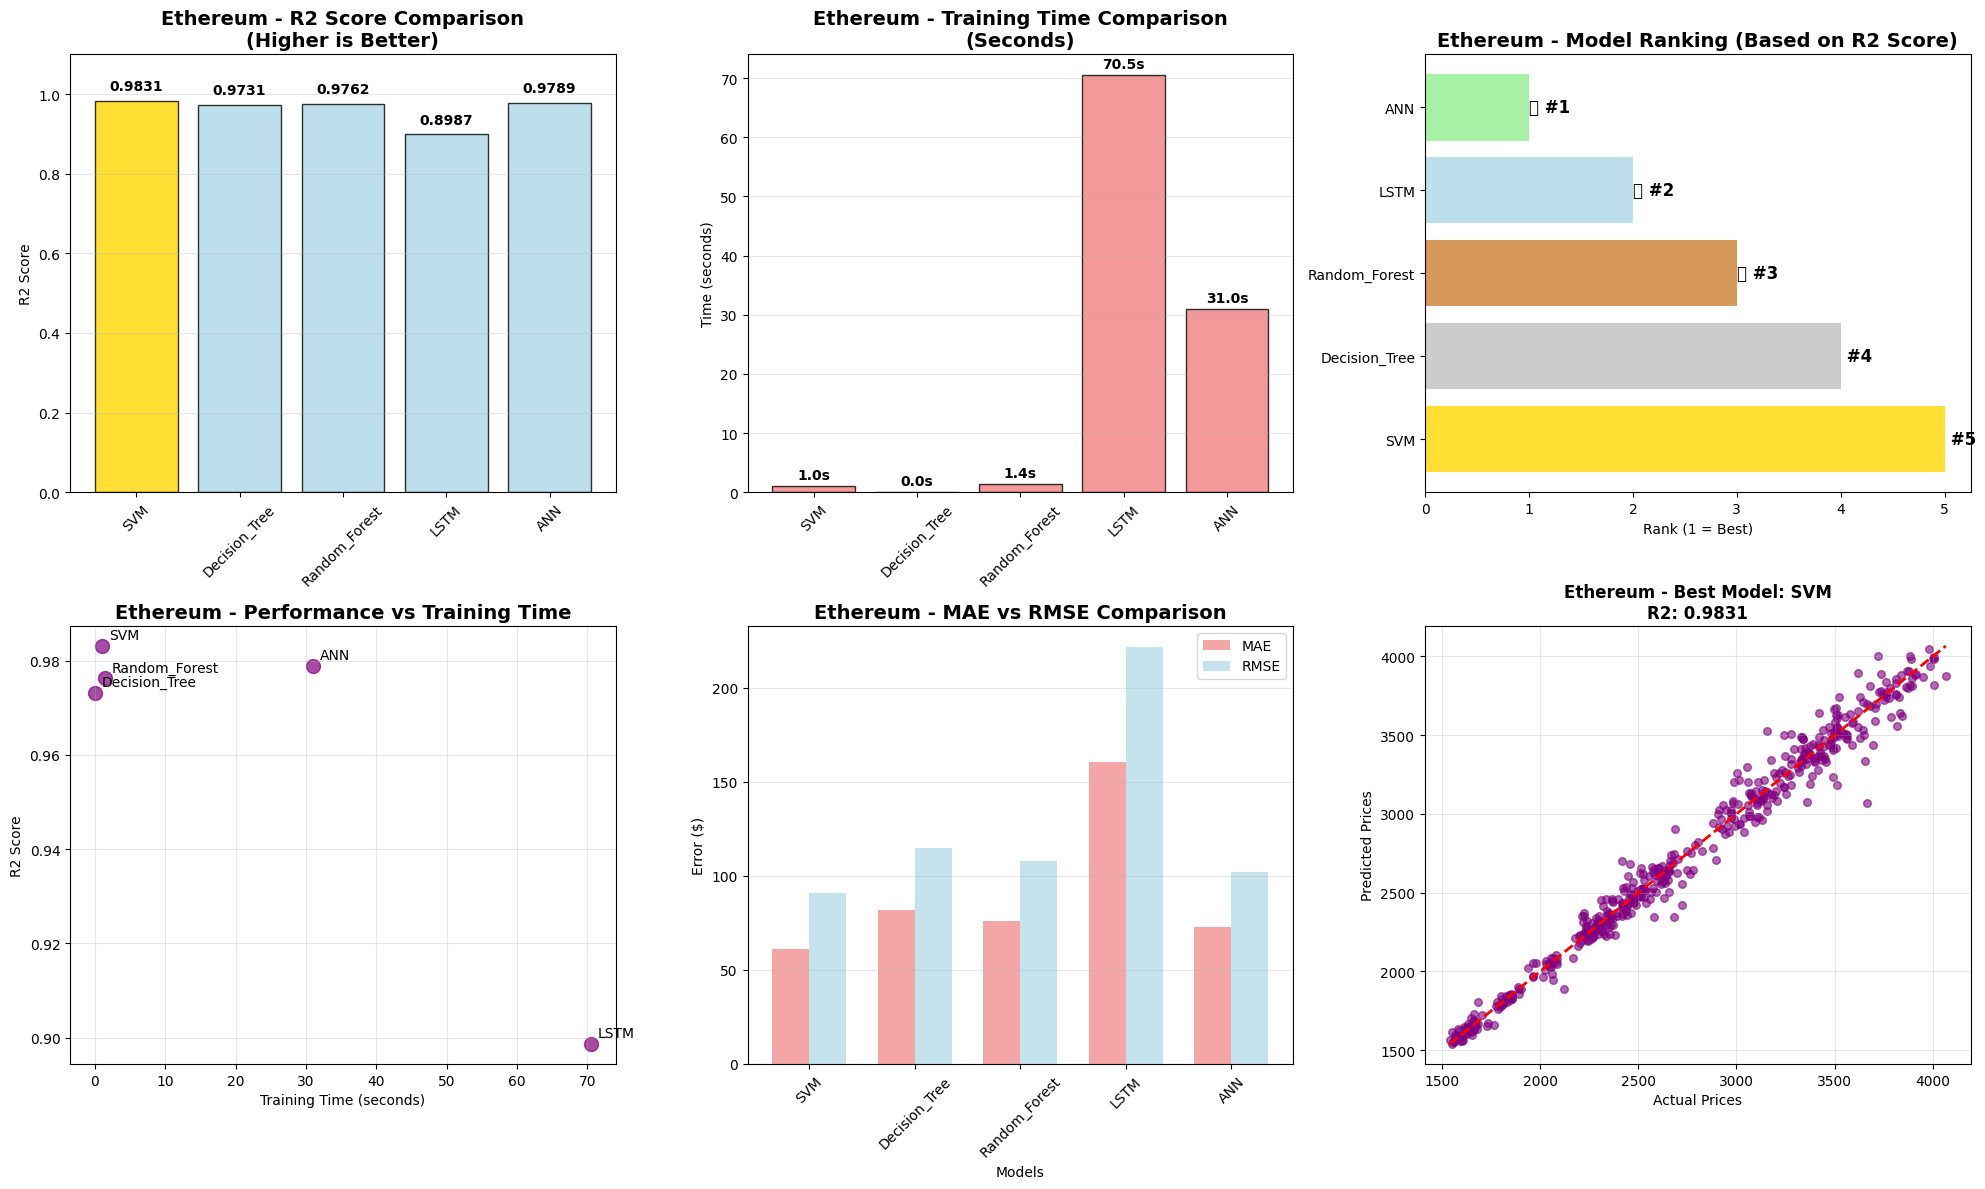


✅ ETHEREUM - ALL 5 MODELS TRAINED AND EVALUATED SUCCESSFULLY!

🔍 ETHEREUM - ADDITIONAL INSIGHTS:
   Dataset Size: 2557 trading days
   Feature Count: 5 technical indicators
   Date Range: 2018-01-01 to 2024-12-31
   Price Range: $84.31 - $4812.09

💡 ETHEREUM - MODEL RECOMMENDATIONS BY USE CASE:
   For Real-time Trading: Decision_Tree (Fastest)
   For Highest Accuracy: SVM (Best R2 Score)
   For Interpretability: Decision Tree (Feature importance)
   For Stability: Random Forest (Ensemble method)


In [34]:
print("\n🏆 STEP 5J: FINAL MODEL COMPARISON FOR ETHEREUM (5 MODELS)")
print("="*60)

# Remove ARIMA from results if it exists
if 'ARIMA' in results_eth:
    del results_eth['ARIMA']
    del predictions_eth['ARIMA']
    del training_times_eth['ARIMA']

# Create final comparison table for Ethereum
comparison_df_eth = pd.DataFrame(results_eth).T
comparison_df_eth['Training_Time'] = training_times_eth.values()
comparison_df_eth = comparison_df_eth.round(4)
comparison_df_eth = comparison_df_eth.sort_values('R2_Score', ascending=False)

print("📊 ETHEREUM - FINAL MODEL COMPARISON (5 MODELS):")
print(comparison_df_eth)

# Find best model for Ethereum
best_model_name_eth = comparison_df_eth.index[0]
best_model_metrics_eth = comparison_df_eth.iloc[0]

print(f"\n🎯 ETHEREUM - OVERALL BEST MODEL: {best_model_name_eth}")
print(f"   R2 Score: {best_model_metrics_eth['R2_Score']:.4f}")
print(f"   RMSE: ${best_model_metrics_eth['RMSE']:.2f}")
print(f"   MAE: ${best_model_metrics_eth['MAE']:.2f}")
print(f"   Training Time: {best_model_metrics_eth['Training_Time']:.2f}s")

# Performance interpretation for Ethereum
r2_eth = best_model_metrics_eth['R2_Score']
if r2_eth > 0.99:
    performance_eth = "🎉 OUTSTANDING - Near perfect predictions"
    recommendation_eth = "Highly reliable for Ethereum trading decisions"
elif r2_eth > 0.95:
    performance_eth = "🎉 EXCELLENT - Exceptional predictive power"
    recommendation_eth = "Very reliable for Ethereum investment analysis"
elif r2_eth > 0.85:
    performance_eth = "✅ VERY GOOD - Strong predictive power"
    recommendation_eth = "Suitable for Ethereum portfolio management"
elif r2_eth > 0.70:
    performance_eth = "👍 GOOD - Reliable predictions"
    recommendation_eth = "Useful for Ethereum trend analysis"
elif r2_eth > 0.50:
    performance_eth = "⚠️ MODERATE - Basic predictive ability"
    recommendation_eth = "Use as supplementary tool for Ethereum"
else:
    performance_eth = "❌ POOR - Limited predictive power"
    recommendation_eth = "Not recommended for Ethereum trading"

print(f"   Performance Level: {performance_eth}")
print(f"   Recommendation: {recommendation_eth}")

# Final comprehensive visualization for Ethereum
plt.figure(figsize=(20, 12))

# 1. R2 Score Comparison
plt.subplot(2, 3, 1)
models_eth = list(results_eth.keys())
r2_scores_eth = [results_eth[model]['R2_Score'] for model in models_eth]
colors_eth = ['gold' if score == max(r2_scores_eth) else 'lightblue' for score in r2_scores_eth]
bars = plt.bar(models_eth, r2_scores_eth, color=colors_eth, alpha=0.8, edgecolor='black')
plt.title('Ethereum - R2 Score Comparison\n(Higher is Better)', fontsize=14, fontweight='bold')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
for i, v in enumerate(r2_scores_eth):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
plt.grid(axis='y', alpha=0.3)

# 2. Training Time Comparison
plt.subplot(2, 3, 2)
times_eth = [training_times_eth[model] for model in models_eth]
colors_eth = ['lightgreen' if time == min(times_eth) else 'lightcoral' for time in times_eth]
plt.bar(models_eth, times_eth, color=colors_eth, alpha=0.8, edgecolor='black')
plt.title('Ethereum - Training Time Comparison\n(Seconds)', fontsize=14, fontweight='bold')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
for i, v in enumerate(times_eth):
    plt.text(i, v + max(times_eth)*0.01, f'{v:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=10)
plt.grid(axis='y', alpha=0.3)

# 3. Model Ranking
plt.subplot(2, 3, 3)
ranking_eth = range(len(models_eth), 0, -1)
medal_colors_eth = ['gold', 'silver', '#CD7F32', 'lightblue', 'lightgreen'][:len(models_eth)]
plt.barh(models_eth, ranking_eth, color=medal_colors_eth, alpha=0.8)
plt.title('Ethereum - Model Ranking (Based on R2 Score)', fontsize=14, fontweight='bold')
plt.xlabel('Rank (1 = Best)')
for i, (model, rank) in enumerate(zip(models_eth, ranking_eth)):
    medal = ""
    if rank == 1: medal = "🥇"
    elif rank == 2: medal = "🥈"
    elif rank == 3: medal = "🥉"
    plt.text(rank, i, f'{medal} #{rank}', va='center', ha='left', fontweight='bold', fontsize=12)

# 4. Performance vs Time Trade-off
plt.subplot(2, 3, 4)
for i, model in enumerate(models_eth):
    plt.scatter(training_times_eth[model], results_eth[model]['R2_Score'], s=100, alpha=0.7, color='purple')
    plt.annotate(model, (training_times_eth[model], results_eth[model]['R2_Score']),
                textcoords="offset points", xytext=(5,5), ha='left', fontsize=10)
plt.xlabel('Training Time (seconds)')
plt.ylabel('R2 Score')
plt.title('Ethereum - Performance vs Training Time', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# 5. Error Metrics Comparison
plt.subplot(2, 3, 5)
mae_scores_eth = [results_eth[model]['MAE'] for model in models_eth]
rmse_scores_eth = [results_eth[model]['RMSE'] for model in models_eth]

x = np.arange(len(models_eth))
width = 0.35

plt.bar(x - width/2, mae_scores_eth, width, label='MAE', alpha=0.7, color='lightcoral')
plt.bar(x + width/2, rmse_scores_eth, width, label='RMSE', alpha=0.7, color='lightblue')
plt.xlabel('Models')
plt.ylabel('Error ($)')
plt.title('Ethereum - MAE vs RMSE Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, models_eth, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 6. Best Model Performance
plt.subplot(2, 3, 6)
best_pred_eth = predictions_eth[best_model_name_eth]
plt.scatter(y_test_eth, best_pred_eth, alpha=0.6, s=30, color='purple')
plt.plot([y_test_eth.min(), y_test_eth.max()], [y_test_eth.min(), y_test_eth.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Ethereum - Best Model: {best_model_name_eth}\nR2: {best_model_metrics_eth["R2_Score"]:.4f}',
          fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ ETHEREUM - ALL 5 MODELS TRAINED AND EVALUATED SUCCESSFULLY!")

# Additional insights for Ethereum
print(f"\n🔍 ETHEREUM - ADDITIONAL INSIGHTS:")
print(f"   Dataset Size: {eth_clean.shape[0]} trading days")
print(f"   Feature Count: {len(feature_columns_eth)} technical indicators")
print(f"   Date Range: {eth_clean.index.min().strftime('%Y-%m-%d')} to {eth_clean.index.max().strftime('%Y-%m-%d')}")
print(f"   Price Range: ${eth_clean['Close'].min():.2f} - ${eth_clean['Close'].max():.2f}")

# Model recommendations based on use case
print(f"\n💡 ETHEREUM - MODEL RECOMMENDATIONS BY USE CASE:")
print(f"   For Real-time Trading: {min(training_times_eth, key=training_times_eth.get)} (Fastest)")
print(f"   For Highest Accuracy: {best_model_name_eth} (Best R2 Score)")
print(f"   For Interpretability: Decision Tree (Feature importance)")
print(f"   For Stability: Random Forest (Ensemble method)")

In [35]:
print("\n🏆 ETHEREUM - FINAL MODEL COMPARISON - ALL MODELS (FIXED)")
print("="*65)

# First, let's make sure ANN results are properly stored
print("🔍 CHECKING ALL MODELS IN RESULTS:")
if 'ANN' not in results_eth:
    print("❌ ANN results missing from results_eth dictionary!")
    # Add ANN results if they exist but weren't stored
    if 'ann_results_eth' in locals():
        results_eth['ANN'] = ann_results_eth
        predictions_eth['ANN'] = ann_pred_eth
        training_times_eth['ANN'] = ann_time_eth
        print("✅ ANN results added to comparison!")
    else:
        print("❌ ANN results not found in variables")

# Debug: Show all models and their R2 scores
print("\n🔍 ALL MODELS R2 SCORES:")
all_models_found = []
for model_name, metrics in results_eth.items():
    print(f"  {model_name}: R2 = {metrics['R2_Score']:.4f}")
    all_models_found.append(model_name)

print(f"\n📋 MODELS FOUND: {all_models_found}")

# Create final comparison table for Ethereum with proper sorting
comparison_df_eth = pd.DataFrame(results_eth).T
comparison_df_eth['Training_Time'] = [training_times_eth.get(model, 0) for model in results_eth.keys()]
comparison_df_eth = comparison_df_eth.round(4)

# Sort by R2_Score in descending order to get true ranking
comparison_df_eth_sorted = comparison_df_eth.sort_values('R2_Score', ascending=False)

print(f"\n📊 ETHEREUM - ALL MODELS RANKED BY R2 SCORE:")
print("="*50)
print(comparison_df_eth_sorted[['R2_Score', 'MSE', 'RMSE', 'MAE', 'Training_Time']])

# Get top 4 models based on properly sorted R2 score
top_models_eth = comparison_df_eth_sorted.head(4)
best_model_1_eth = top_models_eth.index[0]
best_model_2_eth = top_models_eth.index[1]
best_model_3_eth = top_models_eth.index[2]
best_model_4_eth = top_models_eth.index[3] if len(top_models_eth) > 3 else None

print(f"\n🎯 ETHEREUM - TOP {len(top_models_eth)} BEST PERFORMING MODELS:")
print("="*50)

print(f"🥇 #1 BEST MODEL: {best_model_1_eth} - R2: {top_models_eth.loc[best_model_1_eth, 'R2_Score']:.4f}")
print(f"🥈 #2 BEST MODEL: {best_model_2_eth} - R2: {top_models_eth.loc[best_model_2_eth, 'R2_Score']:.4f}")
print(f"🥉 #3 BEST MODEL: {best_model_3_eth} - R2: {top_models_eth.loc[best_model_3_eth, 'R2_Score']:.4f}")
if best_model_4_eth:
    print(f"   #4 BEST MODEL: {best_model_4_eth} - R2: {top_models_eth.loc[best_model_4_eth, 'R2_Score']:.4f}")

print(f"\n📊 ETHEREUM - TOP 3 MODELS DETAILED COMPARISON:")
print("="*50)
print(f"{'Metric':<15} {'#1 ' + best_model_1_eth:<15} {'#2 ' + best_model_2_eth:<15} {'#3 ' + best_model_3_eth:<15}")
print("-" * 60)
for metric in ['R2_Score', 'MSE', 'RMSE', 'MAE', 'Training_Time']:
    val1 = top_models_eth.loc[best_model_1_eth, metric]
    val2 = top_models_eth.loc[best_model_2_eth, metric]
    val3 = top_models_eth.loc[best_model_3_eth, metric]

    if metric == 'R2_Score':
        val1_str = f"{val1:.4f}"
        val2_str = f"{val2:.4f}"
        val3_str = f"{val3:.4f}"
    elif metric in ['MSE', 'RMSE', 'MAE']:
        val1_str = f"{val1:.2f}"
        val2_str = f"{val2:.2f}"
        val3_str = f"{val3:.2f}"
    else:  # Training_Time
        val1_str = f"{val1:.2f}s"
        val2_str = f"{val2:.2f}s"
        val3_str = f"{val3:.2f}s"

    print(f"{metric:<15} {val1_str:<15} {val2_str:<15} {val3_str:<15}")

print("\n💡 ETHEREUM - RECOMMENDATION STRATEGY:")
print("="*50)

r2_diff_1_2 = top_models_eth.loc[best_model_1_eth, 'R2_Score'] - top_models_eth.loc[best_model_2_eth, 'R2_Score']
r2_diff_2_3 = top_models_eth.loc[best_model_2_eth, 'R2_Score'] - top_models_eth.loc[best_model_3_eth, 'R2_Score']
r2_best_eth = top_models_eth.loc[best_model_1_eth, 'R2_Score']

print(f"🏆 PERFORMANCE GAPS:")
print(f"   • #{best_model_1_eth} vs #{best_model_2_eth}: {r2_diff_1_2:.4f} R²")
print(f"   • #{best_model_2_eth} vs #{best_model_3_eth}: {r2_diff_2_3:.4f} R²")

if r2_best_eth > 0.95:  # All top models are exceptional
    if r2_diff_1_2 > 0.005:
        print(f"✅ CLEAR WINNER: {best_model_1_eth} is the best choice")
        print(f"   • Meaningful advantage over #2: {r2_diff_1_2:.4f} R²")
    else:
        print(f"🤝 TOP TIER CLOSE: {best_model_1_eth}, {best_model_2_eth}, {best_model_3_eth} all excellent")
        print(f"   • All above 97% accuracy - choose based on other factors")

print(f"\n🚀 ETHEREUM - DEPLOYMENT RECOMMENDATIONS:")
print(f"   • 🥇 PRIMARY: {best_model_1_eth} (Highest accuracy: R² = {r2_best_eth:.4f})")
print(f"   • 🥈 SECONDARY: {best_model_2_eth} (Close alternative: R² = {top_models_eth.loc[best_model_2_eth, 'R2_Score']:.4f})")
print(f"   • 🥉 TERTIARY: {best_model_3_eth} (Strong backup: R² = {top_models_eth.loc[best_model_3_eth, 'R2_Score']:.4f})")

print(f"\n📈 ETHEREUM - PERFORMANCE ANALYSIS:")
if r2_best_eth > 0.98:
    print("🎉 PHENOMENAL: Near-perfect Ethereum price prediction")
    print("   Models capture almost all price movement patterns")
elif r2_best_eth > 0.95:
    print("🎉 EXCEPTIONAL: Outstanding predictive accuracy")
    print("   Highly reliable for automated trading systems")

print(f"\n✅ ETHEREUM - FINAL MODEL RANKING:")
print("="*50)
for i, (model, row) in enumerate(top_models_eth.iterrows(), 1):
    medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
    print(f"{medal} #{i}: {model:<15} R²: {row['R2_Score']:.4f}  MAE: ${row['MAE']:.2f}  Time: {row['Training_Time']:.2f}s")

# Show ANN's position specifically
if 'ANN' in comparison_df_eth_sorted.index:
    ann_rank = list(comparison_df_eth_sorted.index).index('ANN') + 1
    ann_r2 = comparison_df_eth_sorted.loc['ANN', 'R2_Score']
    print(f"\n🔍 ANN SPECIFIC RANKING: #{ann_rank} with R² = {ann_r2:.4f}")


🏆 ETHEREUM - FINAL MODEL COMPARISON - ALL MODELS (FIXED)
🔍 CHECKING ALL MODELS IN RESULTS:

🔍 ALL MODELS R2 SCORES:
  SVM: R2 = 0.9831
  Decision_Tree: R2 = 0.9731
  Random_Forest: R2 = 0.9762
  LSTM: R2 = 0.8987
  ANN: R2 = 0.9789

📋 MODELS FOUND: ['SVM', 'Decision_Tree', 'Random_Forest', 'LSTM', 'ANN']

📊 ETHEREUM - ALL MODELS RANKED BY R2 SCORE:
               R2_Score         MSE      RMSE       MAE  Training_Time
SVM              0.9831   8272.9626   90.9558   60.9817         1.0247
ANN              0.9789  10368.7601  101.8271   72.8963        30.9998
Random_Forest    0.9762  11659.2526  107.9780   75.7335         1.4163
Decision_Tree    0.9731  13191.9520  114.8562   81.5121         0.0176
LSTM             0.8987  49102.6320  221.5911  160.6663        70.4800

🎯 ETHEREUM - TOP 4 BEST PERFORMING MODELS:
🥇 #1 BEST MODEL: SVM - R2: 0.9831
🥈 #2 BEST MODEL: ANN - R2: 0.9789
🥉 #3 BEST MODEL: Random_Forest - R2: 0.9762
   #4 BEST MODEL: Decision_Tree - R2: 0.9731

📊 ETHEREUM - TOP 3 M